In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pandas as pd
import numpy as np

In [2]:
spark

In [3]:
from pyspark.sql.functions import *

In [4]:
df = spark.read.option("delimiter", ",").csv("appl_accepted_20072019Q3.csv", header=True, inferSchema = True)

In [5]:
df.dtypes

[('id', 'string'),
 ('member_id', 'string'),
 ('loan_amnt', 'double'),
 ('funded_amnt', 'double'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'string'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'string'),
 ('pymnt_plan', 'string'),
 ('url', 'string'),
 ('desc', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'string'),
 ('earliest_cr_line', 'string'),
 ('fico_range_low', 'string'),
 ('fico_range_high', 'string'),
 ('inq_last_6mths', 'string'),
 ('mths_since_last_delinq', 'string'),
 ('mths_since_last_record', 'string'),
 ('open_acc', 'string'),
 ('pub_rec', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 

checking for columns with lot of NULL values

In [6]:
from pyspark.sql.functions import isnan, when, count, col

nan_list = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

In [7]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

0
id                           0
member_id              2650550
loan_amnt                   33
funded_amnt                 33
funded_amnt_inv             33
...                        ...
settlement_status      2615950
settlement_date        2615955
settlement_amount      2615973
settlement_percentage  2615979
settlement_term        2615986

[150 rows x 1 columns]

NaN filter

In [8]:
# number of rows
row_count = df.count()

In [9]:
import pyspark.sql.functions as F

def drop_null_columns(df_orders):
    
    null_counts = df_orders.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_orders.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > row_count*0.6]
    df_orders = df_orders.drop(*to_drop)
    return df_orders

df_nan_filtered = drop_null_columns(df)

In [10]:
len(df_nan_filtered.columns)

108

Getting list of string and numeric columns

In [11]:
str_var = [i[0] for i in df_nan_filtered.dtypes if (i[1]=='string')]
num_var = [i[0] for i in df_nan_filtered.dtypes if ((i[1]=='int') | (i[1]=='double'))]
print('string features :',str_var)
print(len(str_var))
print(' ')
print('numerical features :',num_var)
print(len(num_var))

string features : ['id', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',

Counting number of unique elements in each columns

In [12]:
from pyspark.sql.functions import col, countDistinct

counts = df_nan_filtered.agg(*(countDistinct(col(c)).alias(c) for c in str_var))

In [13]:
counts.count()

1

In [14]:
len(counts.columns)

70

Sort all unique, many unique and some unique.

In [15]:
unique_str_features = []      # categories with unique strings
some_cat_features = []        # 100 categories threshold
many_cat_features = []        # between 100 and uniques

for i in counts.columns:
    print(i)
    decision1 = counts.select(counts[i] < 100).collect()[0]['('+i+' < 100)']
    decision2 = counts.select(counts[i] > row_count*0.85).collect()[0]['('+i+' > '+str(row_count*0.85)+')']
    if(decision1):
        print(' -> added to some')
        some_cat_features.append(i)
    elif(decision2):
        unique_str_features.append(i)
        print(' -> added to unique')
    else:
        many_cat_features.append(i)
        print(' -> added to many')
        
print(unique_str_features)
print(some_cat_features)
print(many_cat_features)

id
 -> added to unique
term
 -> added to some
int_rate
 -> added to many
grade
 -> added to some
sub_grade
 -> added to some
emp_title
 -> added to many
emp_length
 -> added to some
home_ownership
 -> added to some
annual_inc
 -> added to many
verification_status
 -> added to some
issue_d
 -> added to many
loan_status
 -> added to some
pymnt_plan
 -> added to some
url
 -> added to unique
purpose
 -> added to many
title
 -> added to many
zip_code
 -> added to many
addr_state
 -> added to many
dti
 -> added to many
delinq_2yrs
 -> added to many
earliest_cr_line
 -> added to many
fico_range_low
 -> added to many
fico_range_high
 -> added to many
inq_last_6mths
 -> added to many
mths_since_last_delinq
 -> added to many
open_acc
 -> added to many
pub_rec
 -> added to many
revol_bal
 -> added to many
revol_util
 -> added to many
total_acc
 -> added to many
initial_list_status
 -> added to many
out_prncp
 -> added to many
out_prncp_inv
 -> added to many
total_pymnt
 -> added to many
total_pym

check numeric in string columns

In [16]:
from pyspark.sql import functions as F

num_cat = []

for c in many_cat_features:
    col = df_nan_filtered.select(c,F.col(c).cast("double").isNotNull().alias("Value"))#.show()#.alias("Value")
    if(col.groupBy('value').count().orderBy('count', ascending=False).collect()[0]['value']):
        num_cat.append(c)

In [17]:
num_cat

['int_rate',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'avg_cur_bal',
 'bc_util']

In [18]:
from pyspark.sql.functions import col

for c in num_cat:
    df_nan_filtered = df_nan_filtered.withColumn(c,col(c).cast('float'))

In [19]:
str_var = [i[0] for i in df_nan_filtered.dtypes if (i[1]=='string')]
num_var = [i[0] for i in df_nan_filtered.dtypes if ((i[1]=='int') | (i[1]=='double') | (i[1]=='float'))]
print('string features :',str_var)
print(len(str_var))
print(' ')
print('numerical features :',num_var)
print(len(num_var))

string features : ['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'mths_since_last_delinq', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'policy_code', 'application_type', 'acc_now_delinq', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'inq_fi', 'total_cu_tl', 'hardship_flag', 'debt_settlement_flag']
35
 
numerical features : ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_rang

Anonymize dictionary

In [20]:
anonymize = {'url':'image_url' , 'zip_code':'postcode' ,'addr_state':'address'}
primary_key = "id"
sensitive_fields = ['zip_code','addr_state','url']

In [21]:
cat_features = []
cat_features = sensitive_fields + [primary_key] + some_cat_features
cat_features = list(set(cat_features))  # ignore repetation 
print(cat_features)
print(len(cat_features))

['home_ownership', 'application_type', 'open_rv_12m', 'zip_code', 'pymnt_plan', 'verification_status', 'policy_code', 'emp_length', 'grade', 'open_acc_6m', 'open_il_24m', 'acc_now_delinq', 'loan_status', 'debt_settlement_flag', 'open_rv_24m', 'hardship_flag', 'inq_fi', 'open_act_il', 'total_cu_tl', 'term', 'addr_state', 'sub_grade', 'url', 'open_il_12m', 'id']
25


In [22]:
features = cat_features + num_var
print(features)
df_final = df_nan_filtered.select([col for col in features])
df_final = df_final.na.drop() # drop null columns

['home_ownership', 'application_type', 'open_rv_12m', 'zip_code', 'pymnt_plan', 'verification_status', 'policy_code', 'emp_length', 'grade', 'open_acc_6m', 'open_il_24m', 'acc_now_delinq', 'loan_status', 'debt_settlement_flag', 'open_rv_24m', 'hardship_flag', 'inq_fi', 'open_act_il', 'total_cu_tl', 'term', 'addr_state', 'sub_grade', 'url', 'open_il_12m', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_last_12m', 'acc_ope

In [23]:
df_final = df_final.sample(0.003)

In [24]:
data = df_final.toPandas()

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 98 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   home_ownership              2927 non-null   object 
 1   application_type            2927 non-null   object 
 2   open_rv_12m                 2927 non-null   object 
 3   zip_code                    2927 non-null   object 
 4   pymnt_plan                  2927 non-null   object 
 5   verification_status         2927 non-null   object 
 6   policy_code                 2927 non-null   object 
 7   emp_length                  2927 non-null   object 
 8   grade                       2927 non-null   object 
 9   open_acc_6m                 2927 non-null   object 
 10  open_il_24m                 2927 non-null   object 
 11  acc_now_delinq              2927 non-null   object 
 12  loan_status                 2927 non-null   object 
 13  debt_settlement_flag        2927 

In [26]:
from sdv.tabular import CTGAN
#model = CTGAN.load('my_model.pkl')

In [27]:
from sdv.tabular import CTGAN

model = CTGAN(cuda = True, verbose = True ,epochs=500,batch_size=100,generator_dim=(256, 256, 256),discriminator_dim=(256, 256, 256),primary_key =primary_key,anonymize_fields = anonymize)
model.fit(data)

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Epoch 1, Loss G:  1.6211,Loss D: -0.3858
Epoch 2, Loss G:  1.8287,Loss D: -0.1688
Epoch 3, Loss G:  1.6284,Loss D:  0.1243
Epoch 4, Loss G:  2.3382,Loss D: -0.4546
Epoch 5, Loss G:  1.4451,Loss D: -0.6369
Epoch 6, Loss G:  1.9794,Loss D: -0.0178
Epoch 7, Loss G:  1.3541,Loss D:  0.4865
Epoch 8, Loss G:  0.8800,Loss D:  0.1519
Epoch 9, Loss G:  0.8565,Loss D:  0.2113
Epoch 10, Loss G:  0.9716,Loss D: -0.4685
Epoch 11, Loss G:  0.4800,Loss D: -0.1035
Epoch 12, Loss G:  0.8981,Loss D: -0.0401
Epoch 13, Loss G:  1.0158,Loss D: -0.1664
Epoch 14, Loss G:  0.6930,Loss D: -0.1807
Epoch 15, Loss G:  0.8100,Loss D: -0.6208
Epoch 16, Loss G:  0.3900,Loss D: -0.8377
Epoch 17, Loss G: -0.8640,Loss D:  0.7237
Epoch 18, Loss G:  0.2065,Loss D: -0.1400
Epoch 19, Loss G: -1.0467,Loss D: -0.3063
Epoch 20, Loss G: -1.8305,Loss D: -0.6202
Epoch 21, Loss G: -0.9404,Loss D:  0.2287
Epoch 22, Loss G: -1.4195,Loss D: -0.6970
Epoch 23, Loss G: -1.7420,Loss D: -1.1184
Epoch 24, Loss G: -1.8981,Loss D:  0.3322
E

Epoch 195, Loss G: -0.6747,Loss D:  0.8179
Epoch 196, Loss G: -2.7196,Loss D: -0.3488
Epoch 197, Loss G: -1.0567,Loss D:  0.0150
Epoch 198, Loss G:  0.3836,Loss D: -3.4454
Epoch 199, Loss G:  1.8058,Loss D:  2.9762
Epoch 200, Loss G: -0.0163,Loss D: -1.2120
Epoch 201, Loss G: -0.9189,Loss D:  1.1527
Epoch 202, Loss G: -0.8040,Loss D: -0.9952
Epoch 203, Loss G:  0.7505,Loss D: -2.5086
Epoch 204, Loss G:  1.0166,Loss D: -1.3074
Epoch 205, Loss G: -1.8742,Loss D: -1.8461
Epoch 206, Loss G: -0.2413,Loss D: -0.2877
Epoch 207, Loss G:  2.5710,Loss D:  2.1536
Epoch 208, Loss G: -0.2021,Loss D:  0.5204
Epoch 209, Loss G:  0.5147,Loss D: -0.1969
Epoch 210, Loss G:  0.4077,Loss D: -0.5941
Epoch 211, Loss G: -1.0710,Loss D: -2.4110
Epoch 212, Loss G: -0.0074,Loss D: -0.5795
Epoch 213, Loss G:  0.0261,Loss D:  3.4909
Epoch 214, Loss G:  0.0795,Loss D: -1.0117
Epoch 215, Loss G:  2.9043,Loss D:  1.1577
Epoch 216, Loss G: -0.1332,Loss D:  0.0529
Epoch 217, Loss G: -1.1640,Loss D: -0.2653
Epoch 218, 

Epoch 386, Loss G:  0.8477,Loss D: -0.7444
Epoch 387, Loss G: -2.0984,Loss D: -1.6218
Epoch 388, Loss G: -0.6430,Loss D:  0.2513
Epoch 389, Loss G:  0.3519,Loss D: -0.5053
Epoch 390, Loss G: -1.8834,Loss D: -0.7256
Epoch 391, Loss G: -1.2846,Loss D:  0.5800
Epoch 392, Loss G:  0.1356,Loss D: -4.2065
Epoch 393, Loss G:  0.4383,Loss D: -1.0850
Epoch 394, Loss G: -2.5994,Loss D:  0.3439
Epoch 395, Loss G: -4.0022,Loss D: -0.7813
Epoch 396, Loss G:  0.2189,Loss D: -1.4145
Epoch 397, Loss G:  1.9250,Loss D:  1.8901
Epoch 398, Loss G: -1.3587,Loss D:  0.4313
Epoch 399, Loss G: -1.0074,Loss D:  0.2581
Epoch 400, Loss G: -0.4647,Loss D: -2.1939
Epoch 401, Loss G:  1.7711,Loss D:  0.0161
Epoch 402, Loss G:  0.6793,Loss D: -0.5153
Epoch 403, Loss G: -0.9815,Loss D: -1.0693
Epoch 404, Loss G: -0.6688,Loss D: -0.7222
Epoch 405, Loss G:  1.9624,Loss D:  0.4753
Epoch 406, Loss G: -1.8918,Loss D: -3.2928
Epoch 407, Loss G: -0.3423,Loss D:  1.3737
Epoch 408, Loss G:  0.5292,Loss D: -1.3864
Epoch 409, 

In [28]:
model.save('my_model.pkl')

In [29]:
syn_data = model.sample(2912)
syn_data.head(20)

home_ownership application_type open_rv_12m zip_code pymnt_plan  \
0        MORTGAGE       Individual         0.0    13791          n   
1        MORTGAGE       Individual         0.0    73512          n   
2        MORTGAGE       Individual         1.0    49891          n   
3        MORTGAGE       Individual         1.0    11932          n   
4        MORTGAGE       Individual         3.0    71467          n   
5            RENT       Individual         1.0    92375          n   
6        MORTGAGE       Individual         0.0    91730          n   
7            RENT        Joint App         1.0    82687          n   
8             OWN       Individual         1.0    73454          n   
9             OWN       Individual         0.0    04092          n   
10            OWN       Individual         2.0    62297          n   
11           RENT       Individual         0.0    30665          n   
12            OWN       Individual         1.0    69633          n   
13       MORTGAGE       Individual         5.0    68154          n   
14            OWN       Individual         3.0    94577          n   
15           RENT       Individual         4.0    88536          n   
16            OWN       Individual         1.0    72166          n   
17            OWN       Individual         4.0    81870          n   
18            OWN       Individual         0.0    16439          n   
19       MORTGAGE       Individual         6.0    12238          n   

   verification_status policy_code emp_length grade open_acc_6m  ...  \
0      Source Verified         1.0   < 1 year     E         2.0  ...   
1      Source Verified         1.0     1 year     C         0.0  ...   
2             Verified         1.0    5 years     D         0.0  ...   
3      Source Verified         1.0    3 years     B         3.0  ...   
4      Source Verified         1.0    4 years     C         1.0  ...   
5      Source Verified         1.0    5 years     B         1.0  ...   
6      Source Verified         1.0  10+ years     D         0.0  ...   
7             Verified         1.0    5 years     B         2.0  ...   
8             Verified         1.0    2 years     A         1.0  ...   
9             Verified         1.0  10+ years     A         0.0  ...   
10        Not Verified         1.0    4 years     A         3.0  ...   
11        Not Verified         1.0  10+ years     C         0.0  ...   
12     Source Verified         1.0    8 years     C         1.0  ...   
13        Not Verified         1.0  10+ years     C         1.0  ...   
14     Source Verified         1.0    3 years     A         1.0  ...   
15     Source Verified         1.0  10+ years     C         1.0  ...   
16            Verified         1.0  10+ years     A         1.0  ...   
17     Source Verified         1.0    7 years     C         3.0  ...   
18            Verified         1.0  10+ years     B         1.0  ...   
19            Verified         1.0  10+ years     B         2.0  ...   

   num_tl_90g_dpd_24m num_tl_op_past_12m pct_tl_nvr_dlq percent_bc_gt_75  \
0            0.002092          -0.109370      93.035528        18.811477   
1            0.002080           1.831200      76.611582        -1.661234   
2            0.020595           1.954845      79.670234        50.438364   
3           -0.001486           5.347687      96.177529        43.513401   
4            0.001418           2.148955      55.077779        52.328017   
5            0.008828           2.962530     100.124865        -0.821109   
6            0.021252           1.987863      92.537122        43.984147   
7            0.000790           0.991312      95.626696        -1.039165   
8            0.744642           4.202530      86.304323        70.795963   
9           -0.001763          -0.100550     100.093863         0.022347   
10          -0.000024           3.101974      94.951037        40.754397   
11           0.001920          -0.269200      99.406410       109.356391   
12           0.017978          

(2927, 98) (2912, 98)


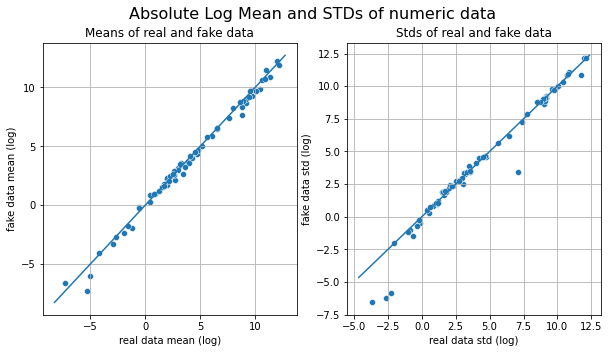

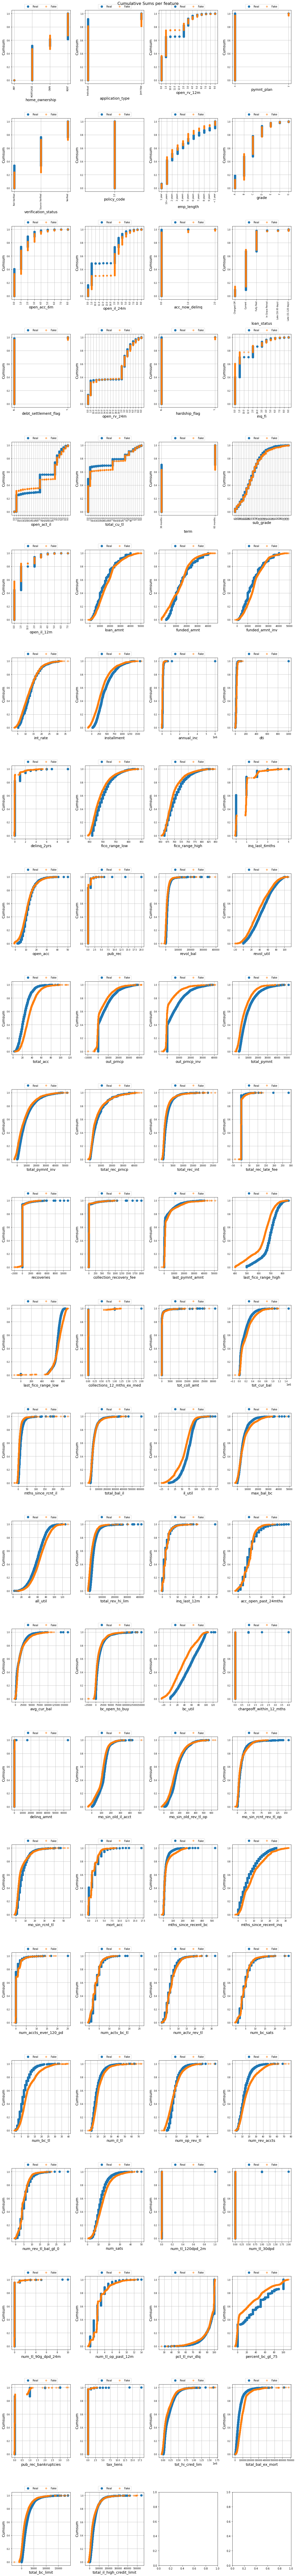

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

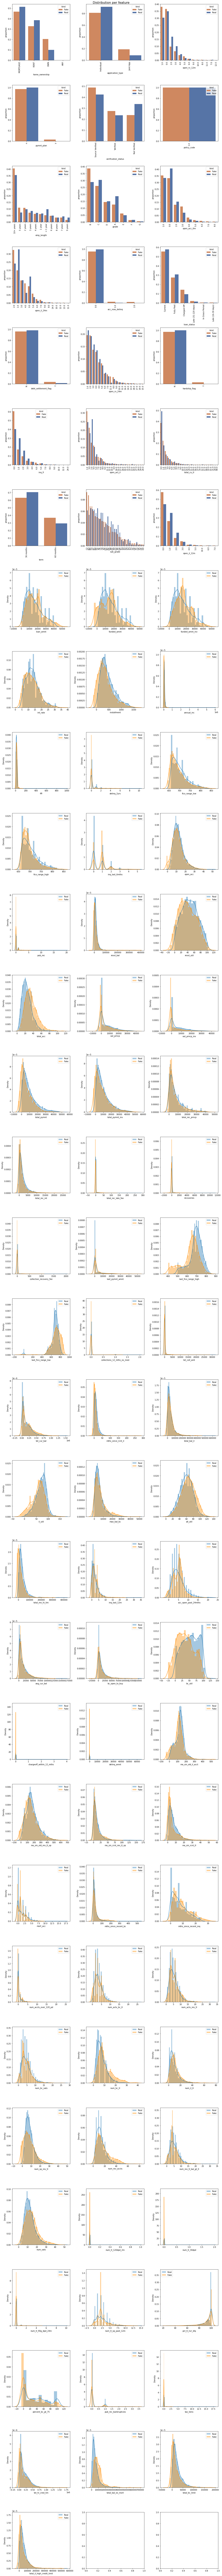

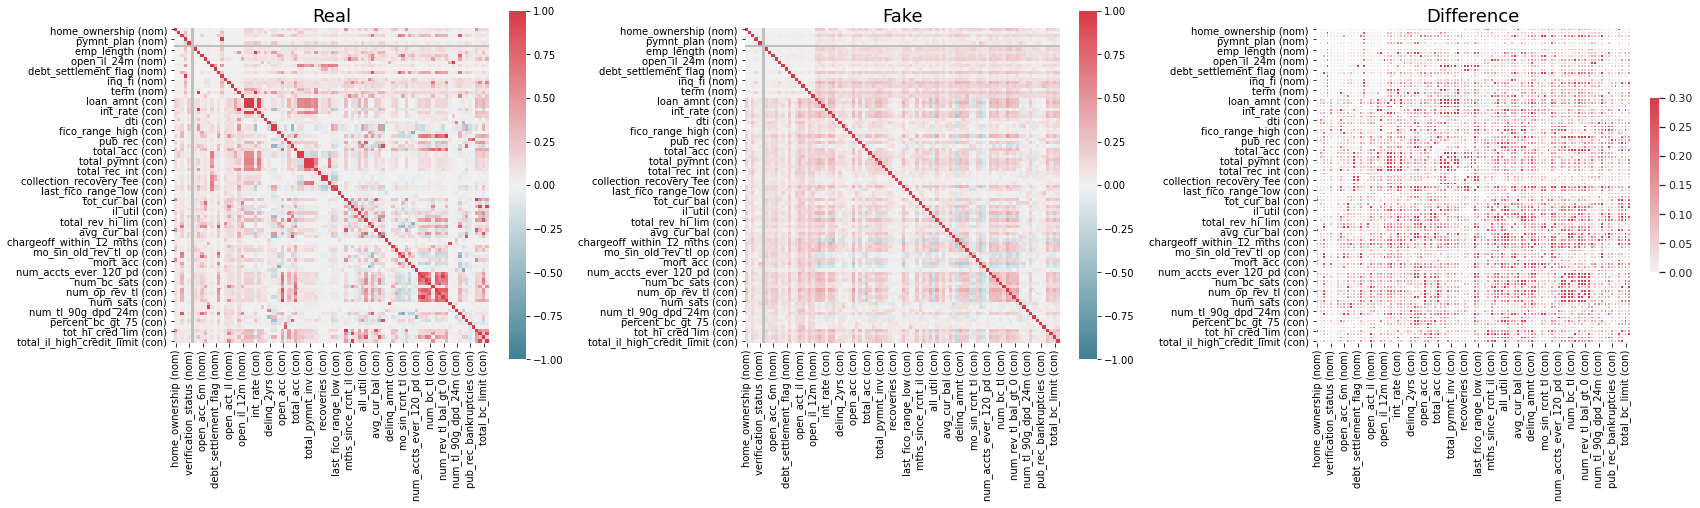

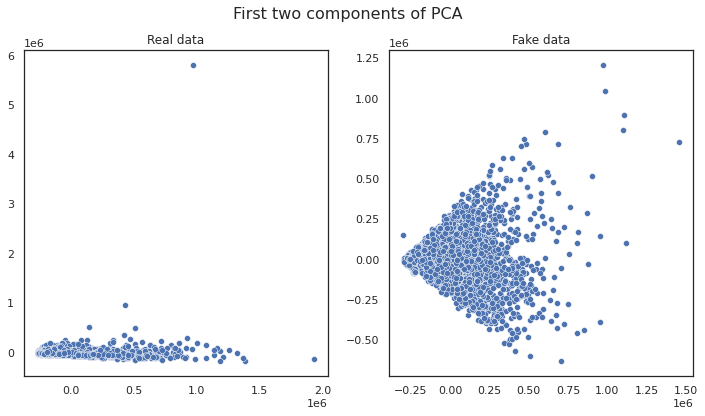

In [30]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_data.shape)
table_evaluator =  TableEvaluator(data.drop(sensitive_fields+[primary_key],axis = 1), syn_data.drop(sensitive_fields+[primary_key],axis = 1))

table_evaluator.visual_evaluation()

In [31]:
from sdv.evaluation import evaluate

evaluate(syn_data.drop(sensitive_fields+[primary_key],axis = 1), data.drop(sensitive_fields+[primary_key],axis = 1), metrics=['CSTest', 'KSTest'], aggregate=False)

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared   0.867804   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.685081   

   normalized_score  min_value  max_value      goal  
0          0.867804        0.0        1.0  MAXIMIZE  
1          0.685081        0.0        1.0  MAXIMIZE

In [32]:
from sdv.tabular import TVAE

model_vae = TVAE(cuda = True,primary_key =primary_key,anonymize_fields = anonymize,epochs=500,compress_dims=(256, 256, 256),decompress_dims=(256, 256, 256))
model_vae.fit(data)

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [33]:
model_vae.save('my_model_vae.pkl')

In [34]:
syn_data_vae = model_vae.sample(2912)
syn_data_vae.head(20)

home_ownership application_type open_rv_12m zip_code pymnt_plan  \
0            RENT       Individual         2.0    96629          n   
1        MORTGAGE       Individual         0.0    86001          n   
2        MORTGAGE       Individual         0.0    03683          n   
3        MORTGAGE       Individual         0.0    10432          n   
4            RENT       Individual         3.0    72992          n   
5        MORTGAGE       Individual         2.0    94532          n   
6        MORTGAGE       Individual         0.0    42018          n   
7            RENT       Individual         1.0    06922          n   
8        MORTGAGE       Individual         1.0    59640          n   
9        MORTGAGE       Individual         0.0    60600          n   
10       MORTGAGE       Individual         1.0    42702          n   
11       MORTGAGE       Individual         0.0    27302          n   
12       MORTGAGE       Individual         1.0    15968          n   
13       MORTGAGE       Individual         0.0    29312          n   
14       MORTGAGE       Individual         1.0    06902          n   
15           RENT       Individual         3.0    73620          n   
16       MORTGAGE       Individual         0.0    65561          n   
17       MORTGAGE       Individual         0.0    60780          n   
18       MORTGAGE       Individual         0.0    51194          n   
19       MORTGAGE       Individual         3.0    16393          n   

   verification_status policy_code emp_length grade open_acc_6m  ...  \
0      Source Verified         1.0  10+ years     B         1.0  ...   
1         Not Verified         1.0  10+ years     B         0.0  ...   
2         Not Verified         1.0  10+ years     A         1.0  ...   
3      Source Verified         1.0  10+ years     C         0.0  ...   
4      Source Verified         1.0  10+ years     D         1.0  ...   
5             Verified         1.0  10+ years     D         2.0  ...   
6      Source Verified         1.0  10+ years     B         0.0  ...   
7         Not Verified         1.0  10+ years     A         1.0  ...   
8      Source Verified         1.0  10+ years     B         1.0  ...   
9      Source Verified         1.0  10+ years     C         0.0  ...   
10     Source Verified         1.0  10+ years     C         1.0  ...   
11            Verified         1.0  10+ years     D         2.0  ...   
12        Not Verified         1.0  10+ years     B         1.0  ...   
13        Not Verified         1.0  10+ years     C         0.0  ...   
14            Verified         1.0  10+ years     C         1.0  ...   
15     Source Verified         1.0  10+ years     C         1.0  ...   
16        Not Verified         1.0  10+ years     A         0.0  ...   
17     Source Verified         1.0  10+ years     C         1.0  ...   
18            Verified         1.0  10+ years     C         1.0  ...   
19            Verified         1.0  10+ years     D         2.0  ...   

   num_tl_90g_dpd_24m num_tl_op_past_12m pct_tl_nvr_dlq percent_bc_gt_75  \
0           -0.000239           2.981891     100.045305        19.859912   
1            0.000913           0.974939     100.035873         0.817328   
2            0.000363           2.004527     100.092687         2.148072   
3            0.000380           0.987762     100.224573        57.156645   
4            0.000088           2.998873     100.191264        61.978737   
5           -0.000078           3.984840      99.813020        -0.297033   
6            0.000186           1.004776      99.933867        65.798139   
7            0.000906           2.020358      99.967054         1.405159   
8            0.000671           1.999008     100.221116        -1.998228   
9           -0.000062           0.991907     100.010332        80.464683   
10           0.000653           2.997934     100.045519        75.954637   
11           0.000150           3.014532      88.305731         0.979958   
12          -0.000677          

(2927, 98) (2912, 98)


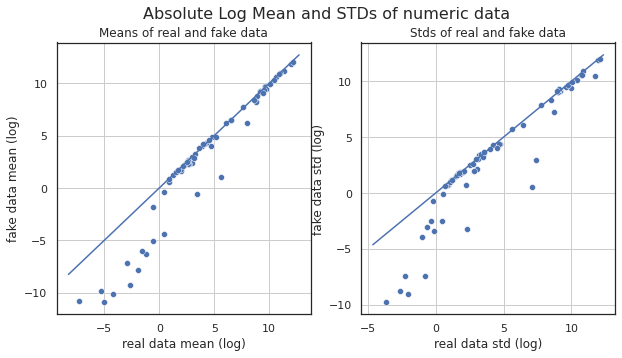

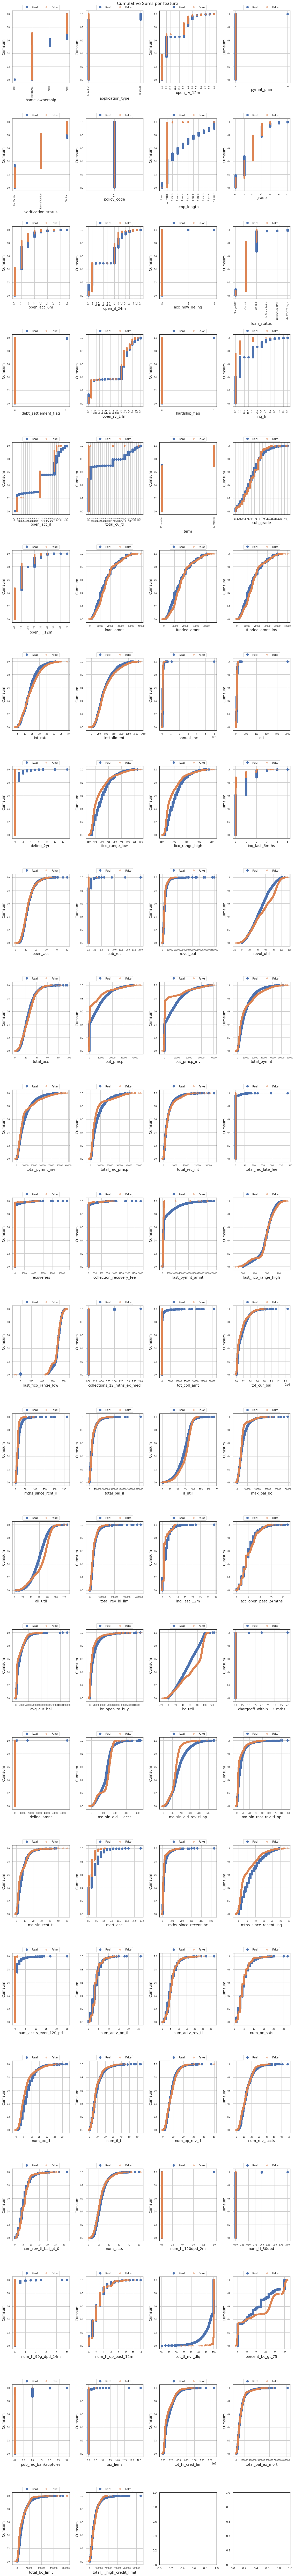

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

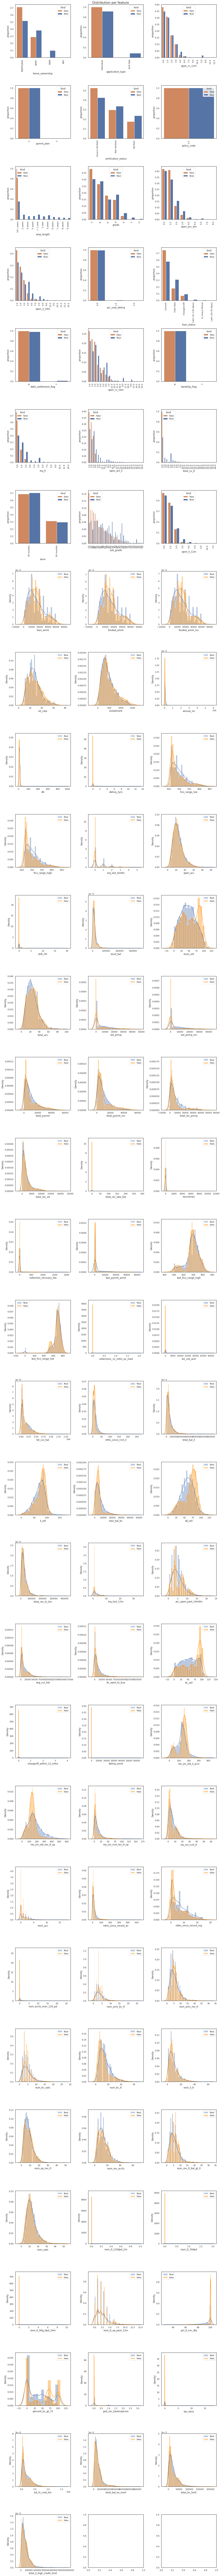

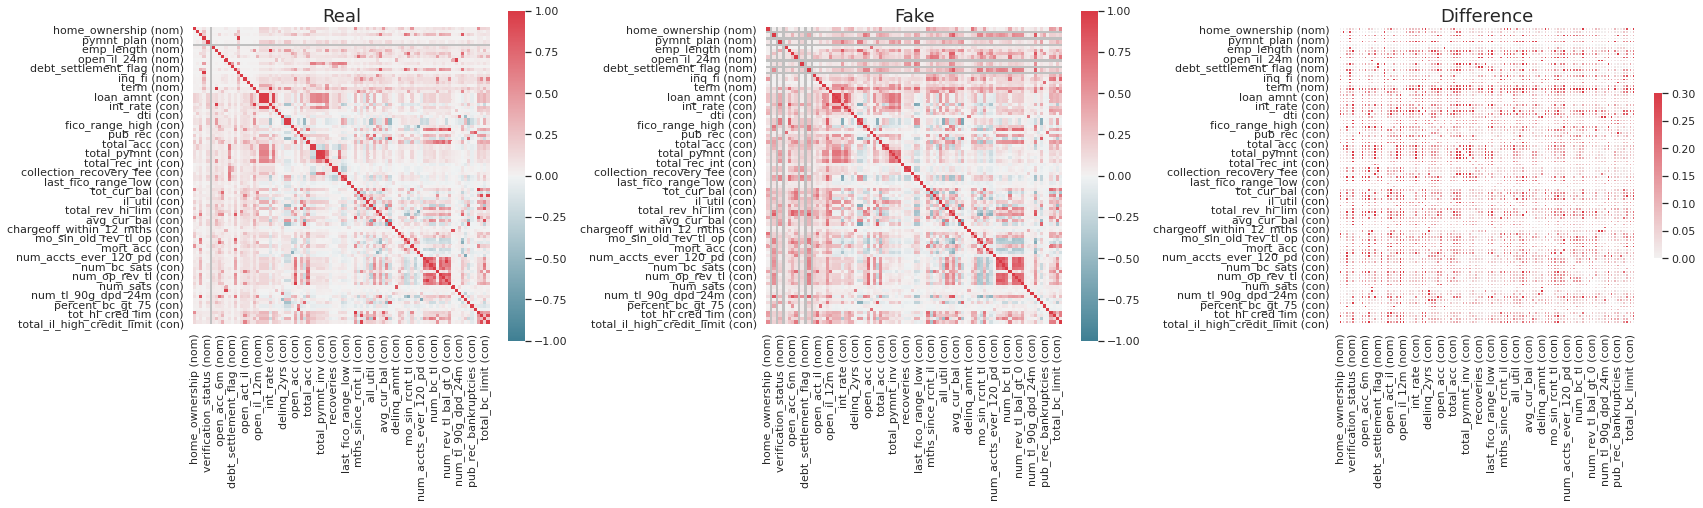

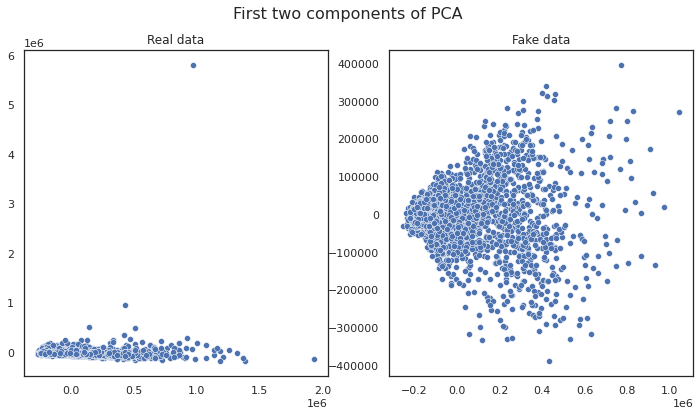

In [35]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_data_vae.shape)
table_evaluator =  TableEvaluator(data.drop(sensitive_fields+[primary_key],axis = 1), syn_data_vae.drop(sensitive_fields+[primary_key],axis = 1))

table_evaluator.visual_evaluation()

In [36]:
from sdv.evaluation import evaluate

evaluate(syn_data_vae.drop(sensitive_fields+[primary_key],axis = 1), data.drop(sensitive_fields+[primary_key],axis = 1), metrics=['CSTest', 'KSTest'], aggregate=False)

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared   0.978693   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.754918   

   normalized_score  min_value  max_value      goal  
0          0.978693        0.0        1.0  MAXIMIZE  
1          0.754918        0.0        1.0  MAXIMIZE

In [37]:
data = data.reindex(columns = features)
syn_data = syn_data.reindex(columns = features)
syn_data_vae = syn_data_vae.reindex(columns = features)

In [38]:
syn_f = pd.concat([syn_data,syn_data_vae])

mix both data

(2927, 98) (5824, 98)


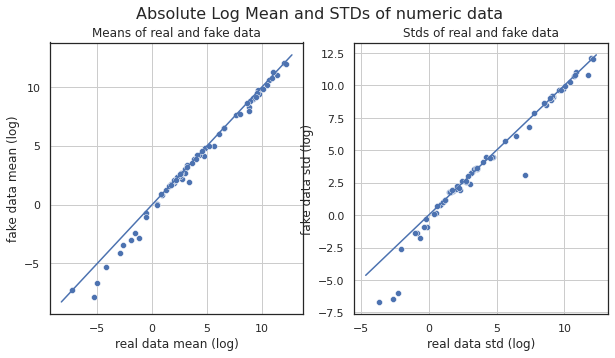

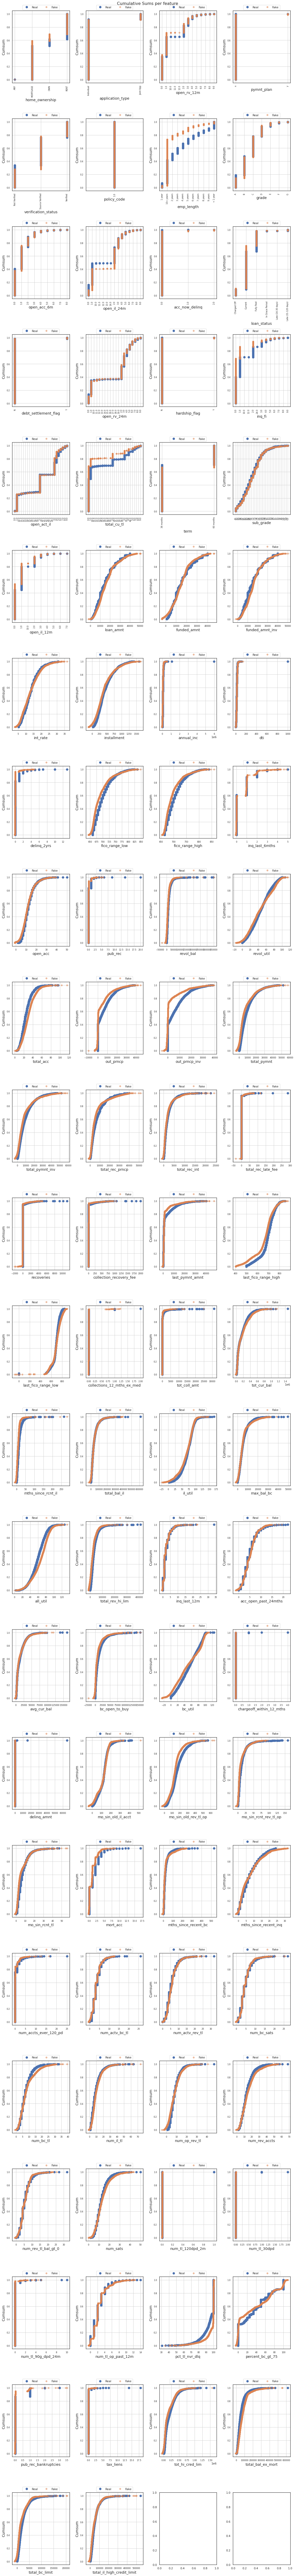

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

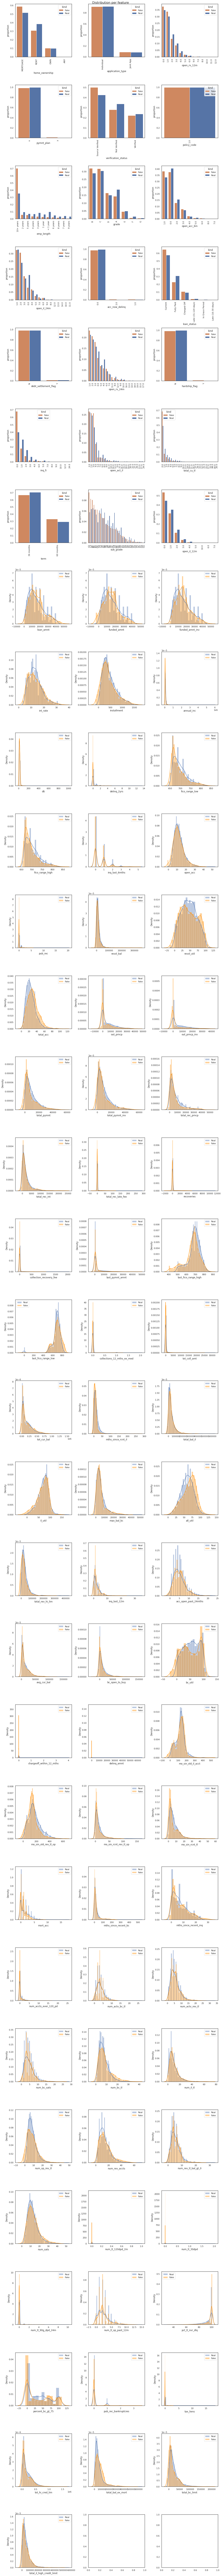

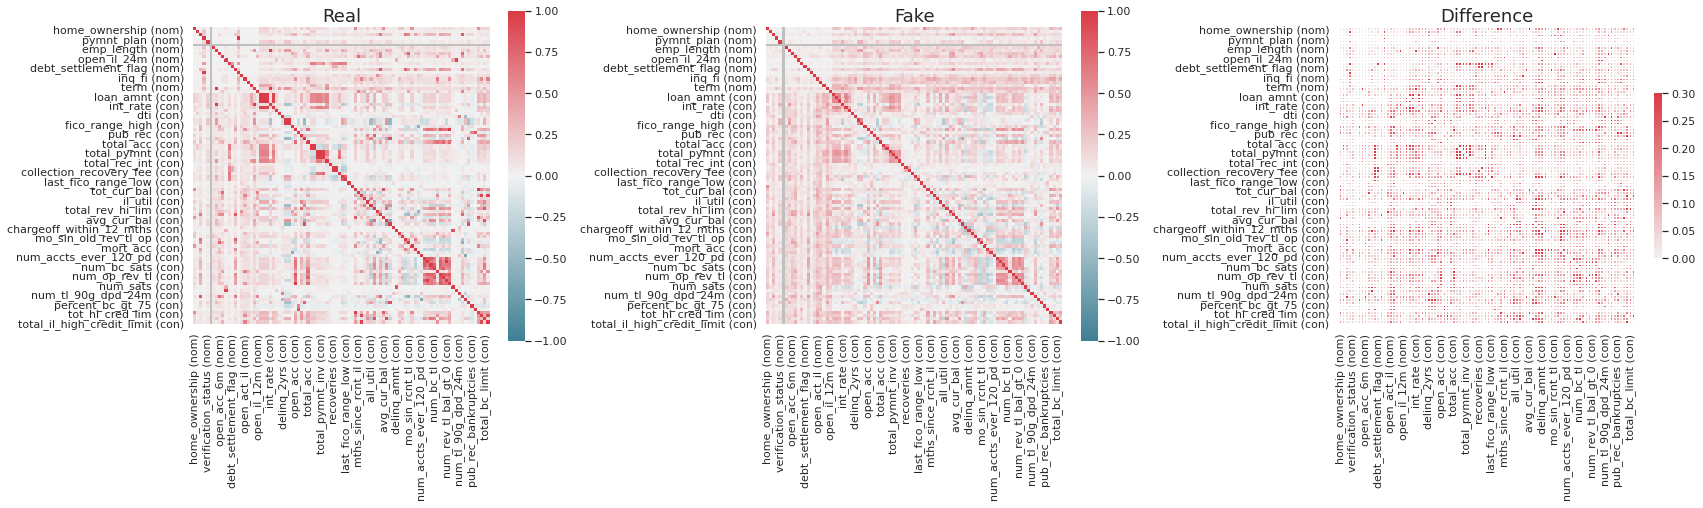

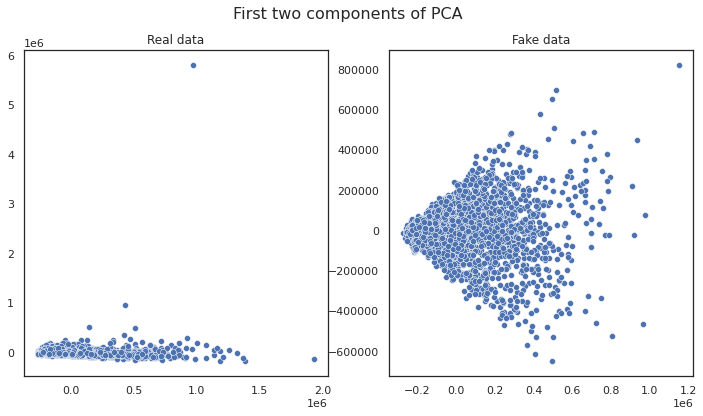

In [40]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_f.shape)
table_evaluator =  TableEvaluator(data.drop(sensitive_fields+[primary_key],axis = 1), syn_f.drop(sensitive_fields+[primary_key],axis = 1))

table_evaluator.visual_evaluation()

In [41]:
from sdv.evaluation import evaluate

evaluate(syn_f.drop(sensitive_fields+[primary_key],axis = 1), data.drop(sensitive_fields+[primary_key],axis = 1), metrics=['CSTest', 'KSTest'], aggregate=False)

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared   0.934367   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.765243   

   normalized_score  min_value  max_value      goal  
0          0.934367        0.0        1.0  MAXIMIZE  
1          0.765243        0.0        1.0  MAXIMIZE

In [ ]:
#df_nan_filtered.select(['revol_bal']).show()

In [ ]:
#spark.stop()

Substitution with fake data

In [ ]:
#df_nan_filtered.select(['addr_state']).show()

In [ ]:
'''from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from faker import Factory

def fake_name():
    faker = Factory.create()
    return faker.address()

fake_name_udf = udf(fake_name, StringType())
df_anon = df_nan_filtered.withColumn('addr_state', fake_name_udf())'''

In [ ]:
#df_anon.select(['addr_state']).show()